In [4]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

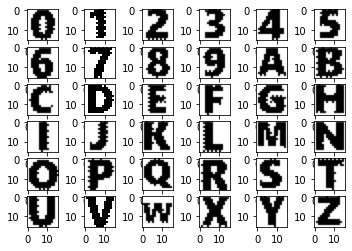

In [6]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet1/' + chr(f(i)) + str(1) + '.PNG'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [150]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, d_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.linear0 = nn.Linear(input_size, d_hidden[0])
        self.activate0 = nn.ReLU()
        self.linear1 = nn.Linear(d_hidden[0], d_hidden[1])
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(d_hidden[1], d_hidden[2])
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(d_hidden[2], d_hidden[3])
        self.activate3 = nn.ReLU()
        self.linear4 = nn.Linear(d_hidden[3],num_classes)
        self.activate4 = nn.Sigmoid()

        
    def forward(self, x):
        res = self.linear0(x)
        res = self.activate0(res)
        res = self.linear1(res)
        res = self.activate1(res)
        res = self.linear2(res)
        res = self.activate2(res)
        res = self.linear3(res)
        res = self.activate3(res)
        res = self.linear4(res)
        res = self.activate4(res)
        return res

In [151]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [152]:
# Parameters of training
learning_rate = 0.001
# Train until the error become the lowest
# get the optimization of MAE or MSE
num_epochs = 600
batch_size, input_size, num_classes = 36, 256, 256
d_hidden=[320, 320, 320, 320]

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, d_hidden=d_hidden,num_classes=num_classes).to(device)

# Setup for noise training
if not os.path.exists('./models1'):
    os.mkdir('./models1')
torch.save(model, './models1/net_untrained.pkl')
for i in range(5):
    if not os.path.exists('./models1/' + str(i) + '/'):
        os.mkdir('./models1/' + str(i) + '/')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [153]:
# Step 3
model = Perceptron(input_size=input_size, d_hidden=d_hidden, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    # research regarding epoch to explain why we need that many iterations (num_epochs)
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = []
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            # data['data'] is each image data in dataset
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2499 MAE: 0.4998 Mean Error: 0.0759 STD: 0.4941
[10/600] Loss: 0.1779 MAE: 0.2967 Mean Error: 0.0238 STD: 0.4211
[20/600] Loss: 0.1534 MAE: 0.3099 Mean Error: -0.0137 STD: 0.3914
[30/600] Loss: 0.1256 MAE: 0.2408 Mean Error: -0.0018 STD: 0.3545
[40/600] Loss: 0.1100 MAE: 0.2237 Mean Error: -0.0046 STD: 0.3317
[50/600] Loss: 0.0994 MAE: 0.1954 Mean Error: 0.0043 STD: 0.3153
[60/600] Loss: 0.0895 MAE: 0.1794 Mean Error: -0.0001 STD: 0.2992
[70/600] Loss: 0.0774 MAE: 0.1587 Mean Error: -0.0015 STD: 0.2783
[80/600] Loss: 0.0633 MAE: 0.1292 Mean Error: -0.0017 STD: 0.2515
[90/600] Loss: 0.0507 MAE: 0.1032 Mean Error: -0.0017 STD: 0.2251
[100/600] Loss: 0.0399 MAE: 0.0825 Mean Error: -0.0014 STD: 0.1998
[110/600] Loss: 0.0315 MAE: 0.0646 Mean Error: 0.0017 STD: 0.1776
[120/600] Loss: 0.0255 MAE: 0.0502 Mean Error: 0.0006 STD: 0.1595
[130/600] Loss: 0.0213 MAE: 0.0392 Mean Error: 0.0013 STD: 0.1460
[140/600] Loss: 0.0190 MAE: 0.0321 Mean Error: 0.0010 STD: 0.1379
[150/600] Los

In [154]:
# Step 4
# Step 4a
# TODO create new for dataset 1
if not os.path.exists('./ass1output'):
    os.mkdir('./ass1output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
output_dataset = np.zeros([36, 256])
output_dataset2 = model(torch.from_numpy(dataSet).float())
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    output_path = './ass1output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array


(36, 256)


(36, 256)


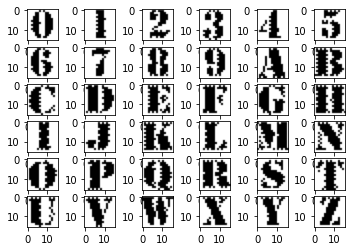

In [155]:
# Step 4
# Step 4b
# Export the image after training
# Before executing this block, create a folder called "output"

# read dataset2 images
dataSet2 = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet2/' + chr(f(i)) + str(2) + '.jpg'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet2[i] = array
dataSet2 = np.array(dataSet2)

if not os.path.exists('./ass2output'):
    os.mkdir('./ass2output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
output_dataset = np.zeros([36, 256])
output_dataset2 = model(torch.from_numpy(dataSet2).float())
output_np = output_dataset2.detach().numpy()
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    output_path2 = './ass2output/' + str(i) + '.png'
    img.save(output_path2)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

In [156]:
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [157]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [158]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

[0.85833333 0.8238342  0.82666667 0.83206107 0.76237624 0.77557756
 0.79137691 0.79528536 0.80043621 0.80528376 0.78584071 0.79264476
 0.79603815 0.8030914  0.80328906 0.81141141 0.81305804 0.81295337
 0.81886603 0.82113427 0.82124943 0.81774264 0.81753948 0.79733438
 0.80014886 0.80455678 0.80901947 0.81074919 0.80850394 0.81230863
 0.81240812 0.80842585 0.80416667 0.8        0.79900158 0.79892693]
[0.07352941 0.05956113 0.07051282 0.09825674 0.09419355 0.09892473
 0.09040075 0.09098229 0.09084355 0.09102731 0.09430605 0.09977703
 0.11653944 0.12118321 0.12262063 0.12176059 0.12226563 0.12621359
 0.11947057 0.12332352 0.12723845 0.12727273 0.13440551 0.1380462
 0.13816321 0.13413049 0.13601004 0.13689605 0.13767945 0.1327594
 0.13252481 0.13357555 0.14232673 0.14231309 0.14124951 0.13938137]


In [159]:
# TODO: Step 4c: Answer 2 questions from canvas
# Step 4d Graph Fh as a function of Ffa for each exemplar in the input dataset
# TODO calculate twice for dataset1 and dataset2

In [160]:
# Step 5
def gaussian_noise(img, mean, sigma, percentage):
    # Generate gauss noise
    print(img)
    gaussian_out=img
    noise = np.random.normal(mean, sigma, int(percentage*256))
    # Add the noise to image
    gp = np.random.uniform(0,255,int(percentage*256))
    for i in range(int(percentage*256)):
        if gaussian_out[int(gp[i])]==1:
            gaussian_out[int(gp[i])]-=abs(noise[i])
        else:
            gaussian_out[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    return gaussian_out

gaussian_dataset = np.zeros([5, 9, 36, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
perc = [0.1, 0.2, 0.25, 0.3, 0.35]

if not os.path.exists('./input_noise2/'):
        os.mkdir('./input_noise2/')
for k in range(5):
    if not os.path.exists('./input_noise2/'+ str(perc[k]) + '/' ):
        os.mkdir('./input_noise2/' + str(perc[k]) + '/' )

for k in range(5):
    for j in range(9):
        if not os.path.exists('./input_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./input_noise2/' + str(perc[k]) + '/' + str(std[j]))
        for i in range(36):
            inputImage = dataSet2[i]
            gaussian_data = gaussian_noise(inputImage, 0, std[j], perc[k])
            img = gaussian_data.reshape(16, 16)*255
            img = Image.fromarray(np.uint8(img))
            img.convert("1")
            
            inputImageDir = './input_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(inputImageDir)
            gaussian_dataset[k][j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)

Fh_noise_array = np.zeros([5, 9, 36])
Ffa_noise_array = np.zeros([5, 9, 36])

# Train 9 datasets with noise
if not os.path.exists('./output_noise2/'):
        os.mkdir('./output_noise2/')
for k in range(5):
    if not os.path.exists('./output_noise2/' + str(perc[k]) + '/'):
        os.mkdir('./output_noise2/' + str(perc[k]) + '/')
for k in range(5):
    for j in range(9):
        train_noise_dataset = DigitDataset(dataset = gaussian_dataset[k][j], label_list = dataSet)
        train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
        print('Training dataset with noise standard deviation ' + str(std[j]))
    #     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
        model_noise = Perceptron(input_size=input_size, d_hidden = d_hidden, num_classes=num_classes).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)

        output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
        torch.save(model_noise, './models2/' + str(k) + '/' + 'net_trained_' + str(std[j]) + '.pkl')
        model_noise = torch.load('./models2/' + str(k) + '/' + 'net_trained_'+ str(std[j]) + '.pkl')
    #     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
        print('------------------------------------')
        output_noise = model_noise(torch.from_numpy(dataSet).float())
        output_noise_np = output_noise.detach().numpy()     # Get the output
    #     print(output_noise_np)
        output_noise_dataset = np.zeros([36, 256])
    #     Make the output only has 0 or 1

        if not os.path.exists('./output_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./output_noise2/' + str(perc[k]) + '/' + str(std[j]))
    
    
        for i in range(36):
            output_noise_img = output_noise_np[i].reshape(16, 16)*255
            img = Image.fromarray(np.uint8(output_noise_img))
            img = img.convert("1")
            output_path = './output_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(output_path)
            data = img.getdata()
            array = np.array(data)/255
            output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    #Fh = calculateFh(dataSet, output_noise_dataset)
    #Ffa = calculateFfa(dataSet, output_noise_dataset)
    #Fh_noise_array[j] = Fh
    #Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.99183907e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.99770490e-01 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.98372182e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.53935202e-04
 9.99615511e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.98740817e-01 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[9.99813678e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99346710e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99022520e-01
 1.00000000e+00 1.00000000e+00 9.99400525e-01 9.99601412e-01
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.98262175e-01 1.00000000e+00
 9.99837794e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99119659e-01
 1.00000000e+00 1.000000

[9.99955884e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99729779e-01
 9.99289000e-01 1.00000000e+00 1.00000000e+00 9.99966923e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99080933e-01
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.98891116e-01 1.00000000e+00 1.00000000e+00 9.99679488e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 3.91646357e-03 3.28216621e-04
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[9.98462400e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99210196e-01
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 9.97541146e-01
 0.00000000e+00 1.00000000e+00 9.95697565e-01 9.99476534e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00094252e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.59123975e-03 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.98527481e-01
 1.00000000e+00 1.00000000e+00 9.97528740e-01 1.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 9.16540515e-04
 0.00000000e+00 0.00000000e+00 3.60093838e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[1.00000000e+00 1.00000000e+00 1.00000000e+00 9.98120687e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00496710e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.96055587e-01 1.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 6.96619946e-04 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.15105969e-03 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00382099e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.99247088e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 3.71621183e-04 2.12762648e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.30044559e-03
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.997100

[1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99605345e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99374477e-01 0.00000000e+00 1.00000000e+00 5.01480930e-04
 1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.99815583e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.89271141e-03 0.00000000e+00 1.19763637e-03
 2.47355598e-03 0.00000000e+00 9.83905912e-04 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.47355817e-03 1.00000000e+00 1.00000000e+00 9.97216352e-01
 1.00000000e+00 9.99474445e-01 0.00000000e+00 0.00000000e+00
 8.69227528e-04 0.00000000e+00 1.00046174e+00 9.97251078e-01
 1.00000000e+00 9.15778707e-04 0.00000000e+00 1.27439026e-04
 0.00000000e+00 3.47677995e-04 9.96630478e-01 1.00000000e+00
 9.98195536e-01 0.000000

[1.00000000e+00 1.00537434e+00 1.00000000e+00 9.95344641e-01
 1.00000000e+00 1.00000000e+00 9.96581993e-01 9.99167443e-01
 1.00000000e+00 1.00000000e+00 9.99755541e-01 9.99346852e-01
 1.00000000e+00 1.00000000e+00 9.97661092e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.95822649e-01 9.98387646e-01 0.00000000e+00 1.00000000e+00
 1.44231718e-03 1.00000000e+00 9.91212500e-01 1.00035795e+00
 0.00000000e+00 1.00000000e+00 9.98536154e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 2.41723726e-05 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.74950442e-03 1.59539407e-03 2.18068478e-04
 3.43349705e-04 0.00000000e+00 1.00339352e+00 1.00000000e+00
 9.98174760e-01 1.00000000e+00 9.98185022e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00262011e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.97580241e-01 1.000000

[1.00000000e+00 9.98717835e-01 9.99582576e-01 9.99496797e-01
 1.00000000e+00 9.99392965e-01 1.00012265e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99609803e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.99396751e-01 9.96976870e-01 1.00000000e+00 0.00000000e+00
 0.00000000e+00 9.98036551e-01 0.00000000e+00 5.01980550e-04
 1.00000000e+00 0.00000000e+00 1.00000000e+00 9.99689946e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 6.89852108e-04 2.69467356e-04 0.00000000e+00
 2.24176037e-03 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.99941899e-01 1.00000000e+00 1.00000000e+00
 9.99167588e-01 1.00000000e+00 9.99141853e-01 8.89534765e-03
 3.34542745e-03 0.00000000e+00 0.00000000e+00 6.03771488e-03
 1.00000000e+00 1.00154937e+00 1.00256588e+00 1.00000000e+00
 9.86039674e-01 9.99249413e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[1.00000000e+00 9.99631019e-01 1.00000000e+00 9.89602594e-01
 1.00000000e+00 9.99906211e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00071196e+00 9.98812614e-01
 9.90336245e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.95957399e-01 1.00000000e+00 1.00158038e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 9.98516388e-01 3.50988981e-03 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.99783396e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.91996721e-01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.73828197e-03 0.00000000e+00 9.99631515e-01 9.99001974e-01
 9.99993828e-01 9.98414660e-01 9.99348622e-01 1.00000000e+00
 3.35141366e-02 0.00000000e+00 9.87217914e-03 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 4.83222620e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

[1.00000000e+00 9.99046375e-01 1.00000000e+00 9.98265654e-01
 1.00000000e+00 1.00143535e+00 9.99269802e-01 9.98327855e-01
 1.00000000e+00 9.99950005e-01 9.99457524e-01 9.99032419e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.91314525e-01 9.98837361e-01 1.00000000e+00 9.99861850e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 9.97251741e-01
 9.99994731e-01 1.00000000e+00 1.00000000e+00 9.97088751e-01
 9.89057126e-01 1.00000000e+00 1.00000000e+00 9.96648976e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000544e+00
 0.00000000e+00 0.00000000e+00 1.81043000e-03 1.00000000e+00
 9.98268850e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00421355e+00 1.00000000e+00 0.00000000e+00
 8.46564624e-03 0.00000000e+00 9.93263621e-01 1.00000000e+00
 9.96850208e-01 1.00000000e+00 0.00000000e+00 9.26994798e-04
 0.00000000e+00 9.97778545e-01 1.00000000e+00 9.95803183e-01
 9.99497701e-01 1.004577

[1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99158034e-01
 1.00000000e+00 1.00000000e+00 9.99657338e-01 1.00000000e+00
 1.00000000e+00 9.99120137e-01 1.00000000e+00 1.00000000e+00
 9.93357339e-01 9.99526675e-01 9.90473680e-01 1.00000000e+00
 9.99930910e-01 9.97897938e-01 1.48682445e-03 1.00000000e+00
 1.16798721e-02 9.97436813e-01 0.00000000e+00 1.00000000e+00
 1.00000000e+00 9.88676246e-01 1.00000000e+00 0.00000000e+00
 9.99508750e-01 1.30222037e-02 1.00000000e+00 9.99016252e-01
 9.99391373e-01 2.40686202e-03 0.00000000e+00 2.99347831e-03
 0.00000000e+00 0.00000000e+00 5.65776711e-04 9.43507220e-03
 1.00786232e+00 1.00000000e+00 0.00000000e+00 1.12891175e-03
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.64928266e-03 0.00000000e+00 1.00000000e+00
 1.00508371e+00 9.97605774e-01 9.93736669e-01 1.00098823e+00
 9.77598390e-04 1.00000000e+00 9.85303712e-01 1.01577287e+00
 1.00000000e+00 9.978294

[1.00000000e+00 9.91569176e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00559154e+00 9.97265118e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99928428e-01
 9.97672909e-01 1.00000000e+00 9.99029823e-01 1.00000000e+00
 9.74198371e-01 1.04333404e+00 9.90362356e-01 9.99458871e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 8.18943527e-03
 1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.01605541e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.95536778e-01
 0.00000000e+00 0.00000000e+00 1.88533632e-03 1.00000000e+00
 1.00000000e+00 4.28028860e-03 0.00000000e+00 9.99803136e-01
 9.97868481e-01 9.82777236e-01 9.98489511e-01 9.81804139e-01
 9.95194364e-01 9.98971190e-01 9.98031200e-01 0.00000000e+00
 4.71252289e-03 0.00000000e+00 7.09194341e-03 9.99442017e-01
 9.98331032e-01 9.99576673e-01 3.06674597e-03 0.00000000e+00
 1.00000000e+00 9.53210748e-01 9.99737263e-01 9.99626112e-01
 9.98266295e-01 1.000000

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.05168631e+00
 1.00000000e+00 9.97389786e-01 1.00692135e+00 1.00000000e+00
 9.89853295e-01 1.00000000e+00 1.00000000e+00 9.82164053e-01
 1.00000000e+00 9.88544382e-01 1.00000000e+00 9.79973542e-01
 9.99374477e-01 0.00000000e+00 1.00000000e+00 8.44558614e-03
 1.00000000e+00 3.58589818e-02 1.00000000e+00 9.61015366e-01
 6.13643906e-03 1.01656805e+00 1.00000000e+00 9.99815583e-01
 1.00000000e+00 9.98365048e-01 9.96661713e-01 1.00000000e+00
 1.00000000e+00 1.89271141e-03 1.58923992e-03 1.19763637e-03
 2.47355598e-03 3.64292181e-03 9.83905912e-04 1.00000000e+00
 8.99630868e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.47355817e-03 1.00000000e+00 1.00000000e+00 9.97216352e-01
 1.00000000e+00 1.02243736e+00 2.41496812e-02 2.88143203e-02
 8.69227528e-04 3.75524708e-03 1.00046174e+00 9.97251078e-01
 9.90988193e-01 9.15778707e-04 0.00000000e+00 1.27439026e-04
 0.00000000e+00 3.47677995e-04 9.96630478e-01 1.00000000e+00
 9.98195536e-01 6.473384

[1.00000000e+00 1.03534108e+00 1.00000000e+00 9.95344641e-01
 1.07518774e+00 1.00000000e+00 9.96581993e-01 9.99167443e-01
 9.72450667e-01 1.00000000e+00 9.99755541e-01 1.06709365e+00
 1.00000000e+00 1.00000000e+00 9.97661092e-01 1.00000000e+00
 9.99574618e-01 9.62368222e-01 9.41947586e-01 1.00000000e+00
 1.01059822e+00 9.98387646e-01 0.00000000e+00 1.00000000e+00
 1.44231718e-03 9.93929828e-01 9.91212500e-01 1.00587818e+00
 4.68885819e-02 1.00000000e+00 9.98536154e-01 9.79075330e-01
 9.98488835e-01 1.00000000e+00 9.65778877e-01 0.00000000e+00
 2.41723726e-05 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.74950442e-03 1.59539407e-03 2.18068478e-04
 3.43349705e-04 0.00000000e+00 1.00339352e+00 1.00000000e+00
 1.00675634e+00 1.00000000e+00 9.98185022e-01 0.00000000e+00
 8.39647076e-03 0.00000000e+00 1.00262011e+00 1.00000000e+00
 9.93098582e-01 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.92594793e-01
 9.97580241e-01 1.000000

[9.60503419e-01 1.00000000e+00 1.07779589e+00 9.99068114e-01
 9.74778472e-01 1.00000000e+00 9.99183907e-01 1.00000000e+00
 9.96678959e-01 9.98717427e-01 1.00000000e+00 9.83086443e-01
 9.79261695e-01 9.93666098e-01 1.00000000e+00 9.97366073e-01
 9.97545504e-01 9.99770490e-01 9.99977818e-01 2.68957656e-03
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00448365e+00 1.08352268e+00 5.60701528e-03 1.00000000e+00
 1.13376939e-02 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.98372182e-01 1.02577195e+00 0.00000000e+00 0.00000000e+00
 7.23413054e-02 0.00000000e+00 2.98555778e-02 4.53935202e-04
 9.99615511e-01 2.57133404e-03 0.00000000e+00 0.00000000e+00
 2.72010608e-02 6.89864847e-03 1.00000000e+00 1.11037765e+00
 9.99006426e-01 1.04131764e+00 1.00000000e+00 0.00000000e+00
 5.07223429e-02 0.00000000e+00 5.97241561e-03 3.26361115e-02
 1.00794066e+00 9.96299431e-01 9.95704207e-01 9.99680506e-01
 0.00000000e+00 1.83671869e-02 9.95599714e-01 1.00000000e+00
 1.00000000e+00 9.926369

[1.00000000e+00 1.09683267e+00 9.94175207e-01 9.98265654e-01
 1.00000000e+00 1.04752983e+00 1.01320851e+00 9.98327855e-01
 1.00000000e+00 1.04604319e+00 9.99457524e-01 1.04822554e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 8.73246038e-01
 9.91314525e-01 9.98837361e-01 1.00000000e+00 1.05825395e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.47024885e-01 0.00000000e+00 9.88812316e-01 9.97251741e-01
 1.02568129e+00 1.00000000e+00 9.96864471e-01 9.97088751e-01
 1.02983207e+00 1.00000000e+00 1.00000000e+00 9.96648976e-01
 6.44486838e-02 0.00000000e+00 5.39476019e-02 1.05004233e+00
 0.00000000e+00 0.00000000e+00 1.81043000e-03 1.00000000e+00
 9.98268850e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00421355e+00 1.00000000e+00 1.41960620e-02
 8.46564624e-03 2.52184853e-02 9.93263621e-01 1.00000000e+00
 9.96850208e-01 1.00000000e+00 0.00000000e+00 9.26994798e-04
 0.00000000e+00 9.98272435e-01 1.00000000e+00 1.17998949e+00
 1.02954121e+00 1.016178

[9.71259472e-01 9.98013442e-01 9.98700273e-01 9.89298691e-01
 9.96123430e-01 1.00000000e+00 9.99257900e-01 9.98702426e-01
 9.60433437e-01 1.00000000e+00 9.43343440e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.80350014e-01 9.88752414e-01
 1.02460090e+00 9.99709531e-01 1.00000000e+00 9.92455545e-01
 1.00021089e+00 1.00000000e+00 1.00989356e-02 1.00000000e+00
 1.00000000e+00 5.33947423e-04 9.99941840e-01 1.00000000e+00
 4.43983234e-02 9.99689673e-01 1.09138066e+00 1.00027121e+00
 1.00000000e+00 1.00055978e+00 9.98973072e-01 1.06773055e+00
 0.00000000e+00 7.92661292e-02 4.76567671e-04 1.03838330e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.64557250e-02 9.99790387e-01 9.91391808e-01 9.99505921e-01
 9.74637936e-01 1.00782139e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 2.59565439e-01 1.01222611e+00 1.00227187e+00
 9.99085168e-01 1.01556564e+00 9.81928316e-01 2.05424086e-02
 0.00000000e+00 1.05304768e+00 1.01917104e+00 9.92271955e-01
 1.00309867e+00 9.962106

[9.99133736e-01 1.00634094e+00 1.00000000e+00 9.41380308e-01
 9.96450597e-01 9.98931398e-01 9.97877217e-01 9.55096355e-01
 9.98884569e-01 9.99921811e-01 1.02429847e+00 9.94698646e-01
 9.71674450e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 4.45609768e-04 4.07635135e-02 4.60752741e-03 0.00000000e+00
 1.06560904e-01 1.93436745e-03 9.99193609e-01 1.00000000e+00
 2.52914366e-05 3.34576420e-03 1.00000000e+00 1.01219335e+00
 0.00000000e+00 8.48131019e-03 3.60558134e-03 5.35582776e-04
 1.14255593e-02 1.32937962e-02 2.05582812e-04 0.00000000e+00
 3.35217056e-04 1.00000000e+00 1.00000000e+00 9.99079953e-01
 2.06587085e-03 7.87125749e-04 9.99578114e-01 1.00095047e+00
 1.00000000e+00 6.09867632e-04 1.01209013e+00 9.17260250e-01
 1.00000000e+00 0.00000000e+00 1.80880230e-03 3.51058474e-02
 0.00000000e+00 9.99407711e-01 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.17258656e-04 9.33284770e-01
 9.51379372e-01 4.68660245e-02 1.12353504e+00 9.60398783e-01
 9.94463688e-01 1.021122

[9.53876675e-01 9.99997319e-01 1.04985936e+00 1.05301482e+00
 9.98858732e-01 1.00000000e+00 1.11632111e+00 1.00000000e+00
 9.97032296e-01 9.99566327e-01 1.00000000e+00 1.00000000e+00
 9.93357339e-01 1.00076428e+00 1.05707872e+00 1.00000000e+00
 1.00134278e+00 9.97897938e-01 5.30242538e-02 1.00000000e+00
 1.39264006e-02 9.98874740e-01 9.85764357e-05 8.69785300e-01
 8.02511029e-01 9.91168078e-01 9.39268407e-01 0.00000000e+00
 9.99508750e-01 1.49096502e-02 9.77681803e-01 1.05300390e+00
 1.08916477e+00 2.40686202e-03 0.00000000e+00 2.99347831e-03
 0.00000000e+00 0.00000000e+00 5.65776711e-04 9.43507220e-03
 1.00786232e+00 1.00000000e+00 0.00000000e+00 1.12891175e-03
 0.00000000e+00 0.00000000e+00 1.00070703e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 3.19663493e-02 1.87681037e-01
 2.59215561e-03 4.64928266e-03 9.46563507e-04 1.00000000e+00
 1.00508371e+00 9.97605774e-01 9.93915999e-01 1.00405663e+00
 9.77598390e-04 9.73566363e-01 9.85303712e-01 1.01584610e+00
 9.99876356e-01 1.050182

[1.00000000e+00 1.02777941e+00 1.00587783e+00 9.94939117e-01
 9.98615766e-01 9.99810046e-01 9.98704330e-01 1.00000000e+00
 1.00000000e+00 9.26353461e-01 1.00142415e+00 9.77698759e-01
 1.00000000e+00 1.30763418e+00 1.08656378e+00 1.00505139e+00
 9.97677957e-01 9.99235679e-01 1.03189862e+00 9.51933185e-01
 9.99337303e-01 4.93952402e-03 9.99871756e-01 0.00000000e+00
 9.97623707e-01 1.09196525e-03 9.72341836e-01 1.16879414e+00
 1.00006557e+00 1.00000000e+00 1.00000000e+00 9.90030092e-01
 8.76294864e-01 1.00115174e+00 9.99173445e-01 9.98945321e-01
 6.46451553e-03 9.98012726e-01 9.64577070e-01 1.00000000e+00
 1.09062471e-02 5.77572456e-03 8.03527678e-03 9.77450579e-01
 9.99100823e-01 9.80817874e-01 1.01422774e+00 9.97973088e-01
 9.99494346e-01 9.95849415e-01 9.99855911e-01 3.83350144e-04
 1.91356420e-01 3.19821463e-04 9.98973014e-01 9.98219173e-01
 1.08770916e-02 8.38474710e-03 2.63303187e-02 1.11813889e-03
 1.00409908e+00 1.00000000e+00 1.00000000e+00 9.97296276e-01
 9.84991136e-01 1.000000

[9.88843495e-01 9.99867761e-01 1.01730411e+00 1.00156007e+00
 1.00000000e+00 1.00184661e+00 1.00271563e+00 1.00078421e+00
 1.00368709e+00 1.00000000e+00 1.00029216e+00 1.00030903e+00
 1.00042143e+00 1.00030540e+00 9.95141774e-01 1.01044649e+00
 9.95781019e-01 9.98067179e-01 3.67883625e-02 2.49367684e-02
 1.00000000e+00 0.00000000e+00 4.82969774e-04 9.99180769e-01
 1.00000000e+00 3.15563193e-02 1.00000000e+00 9.97622346e-01
 9.99961887e-01 9.99456917e-01 1.01621177e+00 1.00000000e+00
 1.00000000e+00 2.04447379e-01 1.40070016e-02 1.31207674e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99942761e-01
 1.00000000e+00 4.16060079e-04 0.00000000e+00 1.48527984e-02
 9.99681550e-01 1.00000000e+00 9.99657221e-01 9.95414251e-01
 9.79262184e-01 1.08135602e+00 1.50024786e-01 0.00000000e+00
 8.21022494e-03 0.00000000e+00 2.90441860e-03 9.65079787e-01
 1.00679874e+00 9.83723247e-01 5.31685507e-02 1.70173297e-02
 1.68849122e-02 9.06550118e-03 9.50070608e-01 1.00000000e+00
 9.99852397e-01 9.973752

[9.20534545e-01 1.00657524e+00 9.96922525e-01 9.40572754e-01
 1.00000000e+00 1.00119622e+00 9.91019218e-01 1.00000000e+00
 9.96961961e-01 9.92090703e-01 1.07112590e+00 1.04527928e+00
 1.00679202e+00 1.02032513e+00 1.00000000e+00 1.07419465e+00
 1.28777388e-03 1.00000000e+00 6.05939070e-02 2.73257899e-02
 1.14085054e-01 1.02354906e+00 9.99874207e-01 1.00186167e+00
 9.95770460e-01 9.92945978e-01 0.00000000e+00 9.99843853e-01
 1.57556181e-03 3.48765535e-05 1.74935114e-02 9.99779552e-01
 1.00000000e+00 5.32327455e-03 2.45246062e-02 8.73182729e-03
 4.01247647e-04 1.48104585e-03 0.00000000e+00 1.00000000e+00
 9.94960353e-01 1.02215492e+00 7.94806916e-03 5.29188225e-02
 4.46315727e-03 0.00000000e+00 1.51227646e-02 1.03488248e+00
 1.00096724e+00 9.98619377e-01 7.27905409e-04 9.08627270e-03
 1.42108417e-02 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.02234229e+00 1.00530278e+00 0.00000000e+00 2.34107490e-03
 1.23596281e-03 5.18790878e-03 5.73862235e-03 1.00000000e+00
 1.04588448e+00 9.976669

[1.00000000e+00 9.42525404e-01 9.97655516e-01 1.00000000e+00
 1.00503430e+00 1.00081661e+00 1.00173474e+00 1.00412333e+00
 1.00459614e+00 1.00020668e+00 9.99532321e-01 9.98947318e-01
 1.00000000e+00 9.99369776e-01 1.09859996e+00 1.00000000e+00
 9.99733334e-01 9.80279174e-01 9.98899966e-01 1.02030040e+00
 0.00000000e+00 7.89728449e-04 9.61199746e-01 1.08535369e-01
 1.04120993e+00 4.46596333e-03 9.98269674e-01 3.76490519e-03
 1.47783030e-02 9.31701716e-01 1.01686122e+00 1.00402355e+00
 9.98359092e-01 9.96040612e-01 1.00486800e+00 1.01610903e+00
 2.56841113e-02 0.00000000e+00 1.00000000e+00 9.27641051e-01
 0.00000000e+00 1.86827717e-04 1.91554896e-03 6.02890040e-03
 1.10457849e-02 1.01023646e+00 9.98149674e-01 8.83902965e-01
 9.99731741e-01 1.00457104e+00 9.98953835e-01 2.76605303e-03
 1.45399122e-03 9.93710075e-01 9.47879443e-01 9.73055913e-01
 3.55077866e-02 0.00000000e+00 9.03347199e-03 8.34969810e-04
 9.97180907e-01 9.95305289e-01 1.00662768e+00 1.00035156e+00
 1.00071340e+00 9.996771

[9.31459512e-01 1.03563870e+00 1.00088128e+00 1.05563276e+00
 9.91154566e-01 1.05929506e+00 1.01532985e+00 1.00820256e+00
 9.85192093e-01 1.00000000e+00 9.44561305e-01 1.00000000e+00
 9.96765832e-01 1.00000000e+00 1.00000000e+00 1.01206861e+00
 1.00000000e+00 9.37911376e-01 9.83541592e-01 1.00629781e+00
 9.89784880e-01 9.90038869e-01 0.00000000e+00 0.00000000e+00
 3.90074794e-03 1.83282138e-02 9.96962522e-01 9.99819401e-01
 1.01988246e+00 1.03535671e+00 1.01846412e+00 1.02472128e+00
 9.94077565e-01 9.99171832e-01 1.00877576e+00 1.00000000e+00
 3.98529653e-02 3.54933799e-03 0.00000000e+00 2.28394308e-02
 2.22711163e-02 0.00000000e+00 8.96357251e-03 3.11223342e-03
 3.25596845e-03 1.00079114e+00 1.00041610e+00 1.07558962e+00
 1.00330683e+00 1.04955790e+00 9.98543130e-01 9.92996095e-01
 0.00000000e+00 2.79938824e-04 2.74246522e-02 0.00000000e+00
 3.50910016e-02 4.95769636e-03 0.00000000e+00 1.89977969e-03
 1.00234520e+00 9.68826689e-01 1.00987109e+00 1.02957849e+00
 1.00136360e+00 1.007231

[1.04513888e+00 1.03534108e+00 1.00479531e+00 9.96376454e-01
 1.07547168e+00 1.00743852e+00 1.03387935e+00 1.00027415e+00
 9.91432152e-01 9.69736998e-01 9.99755541e-01 1.07261259e+00
 9.97429227e-01 1.00000000e+00 1.00001641e+00 1.02099123e+00
 1.03803086e+00 9.62368222e-01 9.41947586e-01 8.56231473e-01
 1.01059822e+00 9.99811908e-01 3.40251609e-02 1.07195830e+00
 1.43747290e-02 1.00638010e+00 1.01743373e+00 1.09354047e+00
 4.71979516e-02 9.94819952e-01 1.07977178e+00 9.81148925e-01
 1.11432757e+00 9.77713687e-01 9.76693546e-01 0.00000000e+00
 2.41723726e-05 2.13607153e-03 9.92196726e-01 1.00000000e+00
 1.00000000e+00 4.01716784e-02 1.07467522e-02 2.18068478e-04
 8.10331758e-03 1.49235766e-02 1.24044881e+00 8.95690378e-01
 1.02232992e+00 1.00000000e+00 1.02299617e+00 8.97927732e-03
 1.08506984e-01 1.69647025e-03 1.05281240e+00 9.97857000e-01
 9.93098582e-01 1.00000000e+00 9.95124018e-01 0.00000000e+00
 1.04966766e-02 9.97344339e-01 1.00000000e+00 9.97443693e-01
 1.00061718e+00 1.000000

[1.00071823e+00 1.16195147e+00 1.01435675e+00 9.98265654e-01
 1.07166983e+00 1.04752983e+00 1.01320851e+00 9.99576204e-01
 9.99350366e-01 1.04695597e+00 1.04834356e+00 1.06389338e+00
 9.92403962e-01 1.02511963e+00 1.04266672e+00 8.73246038e-01
 9.94201917e-01 1.02436490e+00 1.02070683e+00 1.06330158e+00
 1.02954750e+00 9.99187917e-01 9.94937746e-01 1.04391858e+00
 9.47024885e-01 6.14750578e-02 9.90958886e-01 9.97251741e-01
 1.02960897e+00 9.97266962e-01 9.96864471e-01 1.00707855e+00
 1.03675833e+00 9.99999034e-01 9.96078294e-01 9.96648976e-01
 6.68075398e-02 6.88331238e-03 5.39476019e-02 1.05209417e+00
 0.00000000e+00 5.29998744e-03 1.81043000e-03 9.93139060e-01
 1.00123125e+00 9.87876380e-01 1.04803413e+00 9.91939143e-01
 9.98029058e-01 1.00421355e+00 1.00269936e+00 1.41960620e-02
 1.29980394e-02 3.88246695e-02 9.97995522e-01 9.96709341e-01
 9.97188647e-01 9.91668034e-01 2.89784216e-02 9.26994798e-04
 3.52094555e-02 1.02868142e+00 1.00000000e+00 1.18737938e+00
 1.04640496e+00 1.016178

[1.00000000e+00 1.02738815e+00 1.03107073e+00 1.03042208e+00
 9.90845494e-01 1.00000000e+00 9.98720791e-01 1.00267788e+00
 1.04377688e+00 9.71755758e-01 9.32296506e-01 9.87444442e-01
 1.05079338e+00 1.10019754e+00 1.08194299e+00 1.08652215e+00
 1.15386911e+00 1.01393241e+00 9.54420152e-01 1.03888834e+00
 1.01650912e+00 1.06583006e+00 2.28522624e-02 1.20581632e+00
 4.94553966e-02 9.97899380e-01 8.76554993e-01 1.00710705e+00
 9.94057337e-01 9.94552321e-01 9.99948621e-01 9.86541473e-01
 1.17675043e+00 1.00000000e+00 1.30739622e+00 1.00132231e+00
 6.15705447e-03 9.82787303e-03 1.06482313e+00 1.06917893e+00
 1.01144948e+00 1.02710535e-01 0.00000000e+00 1.01109386e+00
 1.00456502e+00 9.97511998e-01 9.95032462e-01 1.04717600e+00
 9.99519863e-01 1.00148641e+00 1.07255814e+00 1.09681492e+00
 5.80515895e-02 2.09664165e-02 1.00836126e+00 1.01529149e+00
 9.88262621e-01 1.15656616e-03 0.00000000e+00 2.58031457e-02
 1.00000000e+00 9.91118863e-01 1.00042472e+00 1.13333272e+00
 1.08262699e+00 9.897540

[1.00416908e+00 1.05474278e+00 9.72812758e-01 1.14552003e+00
 9.96344975e-01 1.04656850e+00 9.97515252e-01 9.93323711e-01
 9.98760280e-01 1.03939229e+00 9.78532313e-01 1.16884607e+00
 1.12537833e+00 9.58292081e-01 1.27512956e+00 9.81373706e-01
 9.74198371e-01 1.12156030e+00 9.92280060e-01 1.00068659e+00
 9.74855696e-01 1.00453832e-01 1.03355402e+00 2.48322547e-02
 9.97575183e-01 1.66325795e-01 9.23372869e-01 1.04047125e+00
 1.03501033e+00 1.02281917e+00 1.03669767e+00 9.81506374e-01
 1.00000000e+00 1.00029663e+00 1.16679255e+00 1.03074430e+00
 0.00000000e+00 1.60179987e-02 1.52772556e-01 9.61782447e-01
 1.00397826e+00 3.86572680e-02 6.98347262e-03 1.00339272e+00
 9.97868481e-01 1.08877254e+00 1.00226441e+00 1.00917746e+00
 1.01587340e+00 1.00986001e+00 9.98031200e-01 1.01315588e-01
 2.36292103e-02 6.27434180e-03 7.09194341e-03 1.10971053e+00
 1.27995375e+00 1.16572319e+00 6.23559979e-02 1.02753053e-02
 1.00176838e+00 9.88259974e-01 1.03086976e+00 1.08085122e+00
 1.01500271e+00 9.792334

[9.58378769e-01 1.00657524e+00 1.20848886e+00 9.45441892e-01
 1.00000000e+00 1.00119622e+00 1.03825310e+00 1.00000000e+00
 1.00772836e+00 1.00432759e+00 1.09537820e+00 1.05534663e+00
 1.16199684e+00 1.04129680e+00 1.00000000e+00 1.17262178e+00
 4.90018377e-02 1.00000000e+00 6.05939070e-02 3.50023588e-02
 1.23269717e-01 1.02474662e+00 1.02372082e+00 1.00186167e+00
 9.95770460e-01 1.01030577e+00 1.20004158e-02 9.99843853e-01
 1.57556181e-03 3.02068973e-03 1.76697421e-02 1.06941132e+00
 1.00670526e+00 8.52074731e-03 3.42737173e-02 1.17487031e-02
 4.01247647e-04 1.17694236e-02 2.15374921e-02 1.01572090e+00
 1.09504132e+00 1.08686431e+00 7.94806916e-03 5.29188225e-02
 3.40872202e-02 6.96891363e-02 8.65779325e-02 1.03488248e+00
 1.06178684e+00 9.98619377e-01 7.27905409e-04 9.08627270e-03
 2.52927004e-02 1.04036849e-01 0.00000000e+00 1.00000000e+00
 1.02241397e+00 1.01546646e+00 1.90026017e-04 8.66504754e-03
 1.27683197e-01 5.51403298e-03 5.73862235e-03 1.13126274e+00
 1.10368279e+00 1.043782

[9.60363454e-01 1.14648928e+00 1.08559465e+00 1.05301482e+00
 1.03687254e+00 9.94460000e-01 1.11632111e+00 1.00000000e+00
 1.01227716e+00 1.04516325e+00 9.52244182e-01 1.12825588e+00
 1.03275868e+00 1.02290369e+00 1.10425590e+00 1.00566680e+00
 1.00134278e+00 9.97897938e-01 8.07248309e-02 1.00000000e+00
 1.40776585e-02 1.01891591e+00 8.06316090e-03 8.69785300e-01
 9.88152494e-01 9.91168078e-01 9.50580198e-01 5.04443931e-03
 9.99873430e-01 2.17390626e-02 1.21167920e+00 1.14388777e+00
 1.08916477e+00 3.11091815e-02 1.03990210e-01 2.99347831e-03
 4.54618814e-05 5.89360097e-02 5.65776711e-04 1.44503010e-02
 1.05364164e+00 1.00010732e+00 7.25515134e-02 1.46368211e-02
 8.83607595e-02 1.71135743e-02 1.00088765e+00 9.92836303e-01
 1.23622964e+00 9.96833702e-01 7.29952761e-02 3.43442710e-01
 2.59215561e-03 7.66582569e-03 9.88864240e-04 1.03798042e+00
 1.00996117e+00 1.03379122e+00 9.94056405e-01 1.07428232e+00
 4.11148992e-02 9.98246003e-01 1.10916006e+00 1.03417748e+00
 9.99876356e-01 1.090465

[1.00000000e+00 1.00851072e+00 1.03794628e+00 1.01125752e+00
 1.00585615e+00 1.01231220e+00 1.06746989e+00 1.04402381e+00
 1.00689593e+00 1.03012117e+00 1.03540177e+00 9.99387917e-01
 9.99175821e-01 1.02228750e+00 1.00197066e+00 9.82614186e-01
 1.02358472e+00 1.00574927e+00 1.05127807e+00 1.00194533e+00
 9.99051522e-01 1.00666457e+00 3.87256166e-03 9.93480155e-01
 1.16346372e-02 6.52273638e-02 9.95496568e-01 1.00386501e+00
 8.73301397e-01 9.98761605e-01 1.05146259e+00 1.02801520e+00
 1.01487407e+00 9.98972559e-01 9.99018712e-01 1.00235564e+00
 1.00709253e+00 1.00098177e+00 2.28622619e-01 8.25913405e-03
 6.64990274e-03 3.56531043e-02 4.08722065e-02 1.01702205e+00
 1.15493409e+00 1.02040815e+00 9.99422999e-01 9.98664180e-01
 9.97851713e-01 1.07716029e+00 1.01142924e+00 1.16136995e+00
 1.00331234e+00 1.00252295e+00 1.01661136e-02 9.16246744e-03
 9.09154587e-03 2.30944475e-02 1.70793482e-01 1.03005109e+00
 1.04083821e+00 1.00620994e+00 1.04170999e+00 1.02811704e+00
 1.07946762e+00 9.902226

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1.25271538e+00 1.05315494e+00 1.03227083e+00 1.10699623e+00
 1.14837353e+00 1.21029209e+00 1.04900726e+00 1.18321998e+00
 1.00795454e+00 1.16290139e+00 1.00817765e+00 1.01856615e+00
 1.03698467e+00 1.02824606e+00 9.93836218e-01 1.10210411e+00
 1.02979534e+00 1.03934857e+00 1.06209378e+00 1.06041257e+00
 1.05252385e+00 1.19064981e+00 1.10441729e-01 1.00078094e+00
 1.02259629e+00 9.62603800e-04 1.03370071e+00 9.88678503e-01
 6.50225374e-02 1.03158212e+00 1.24026333e+00 1.10021489e+00
 1.07530311e+00 1.02337877e+00 1.05877334e+00 1.07126869e+00
 1.64415144e-01 9.90264129e-02 5.36723097e-02 1.05850362e+00
 1.00051556e+00 0.00000000e+00 4.66316839e-01 1.21504553e-01
 1.03408720e-01 1.07132622e+00 1.01406399e+00 1.03217563e+00
 1.08409929e+00 1.05695148e+00 9.92583237e-01 7.31455072e-02
 2.59890984e-01 2.59565439e-01 1.03674998e+00 1.19134901e+00
 1.15739643e+00 1.08167109e+00 1.01213410e+00 1.42682689e-01
 2.16612534e-01 1.45592080e+00 1.09389752e+00 9.93044514e-01
 1.05134283e+00 1.255405

[1.         1.03497884 1.03315342 1.03042208 1.06821341 1.009133
 1.21642087 1.01029716 1.10915863 0.97348217 0.94920873 1.23437326
 1.23511832 1.18434058 1.08803016 1.09569473 1.24557181 1.08287586
 0.95633475 1.13016538 1.06697121 1.15143916 0.02577131 1.23029349
 0.06175322 1.27711485 0.88496775 1.01238366 0.99926585 1.00199425
 1.17476537 1.01686382 1.18813533 0.99619401 1.34062526 1.08006078
 0.08759718 0.01707461 1.06523185 1.06917893 1.01144948 0.11885282
 0.0610892  1.01234259 1.05627741 1.07307837 1.03679192 1.06650458
 1.00251185 1.06887344 1.0976597  1.23139917 0.06033149 0.02343257
 1.03326128 1.01537075 0.98850664 0.01480444 0.01891181 0.0771412
 1.00210402 0.99263107 1.03063794 1.16522996 1.0969777  1.048832
 1.10397079 0.10521208 0.03530525 0.00643722 1.03190135 1.00027736
 0.99081702 0.18584429 0.25147542 0.11710575 1.2557532  1.05043928
 1.04134365 1.13837501 0.99934027 1.04835195 1.07606569 0.01692581
 0.26658264 0.11688588 1.10894873 1.16984532 1.02574484 0.11128547


[0.99016065 1.06422803 1.09579538 0.99940914 1.2381302  1.06519784
 1.04508803 1.25927906 1.12194488 1.0750628  1.03088338 0.99836105
 1.09818427 1.0136592  1.00021869 1.12183225 1.04670823 1.06192397
 1.06408237 1.04227432 1.05642873 0.20999173 0.05062598 1.05002726
 0.0423314  0.05348848 1.11481593 0.95418373 0.99500674 1.10954929
 1.00034888 1.10495839 1.06220979 1.00343789 1.23029476 1.04430747
 0.07456217 0.0426723  0.09224652 1.10096894 1.04719277 0.10950278
 0.05379482 0.06007315 1.0089218  1.01318965 0.94095329 0.9918375
 1.17268798 1.01372731 1.05435993 1.02399552 0.04624143 0.0244436
 0.16633042 1.05432297 1.04100692 0.07540688 0.05692468 0.1227174
 0.08092507 1.00661189 1.02077924 1.1599494  1.04667072 1.04769189
 1.10352244 0.26782401 0.03133243 0.02169925 0.0572357  1.08458252
 1.17844434 1.15575751 0.23325654 0.03544521 0.03474611 1.17557398
 0.99961184 1.07322375 1.00181418 0.95716037 1.02361722 1.16997966
 0.03184803 0.02393856 0.14409664 1.091697   1.04153154 0.1720082

[1.29892800e+00 1.07989623e+00 1.07072610e+00 1.03674696e+00
 1.14853604e+00 1.01010769e+00 1.04331697e+00 1.25996563e+00
 1.00382473e+00 9.90473826e-01 1.00326455e+00 1.07759653e+00
 1.04246312e+00 1.09830459e+00 1.11052486e+00 1.08162503e+00
 1.17377454e+00 1.04370577e+00 9.92990152e-01 9.21704958e-01
 1.15476993e+00 1.02645171e+00 9.52950312e-02 1.15619911e+00
 1.29019126e-01 1.03585067e+00 1.09407312e+00 1.20036839e+00
 1.13678081e-01 9.95971231e-01 1.09364889e+00 1.09126543e+00
 1.20497777e+00 9.98806649e-01 1.02968466e+00 6.00049248e-02
 2.25779690e-02 2.06836138e-01 9.92467140e-01 1.08671789e+00
 9.39917821e-01 6.39964031e-02 1.16638590e-02 8.12440125e-02
 1.72022939e-01 8.30199241e-02 1.39542115e+00 1.01421471e+00
 1.02245625e+00 9.04579260e-01 1.16168107e+00 3.61572143e-02
 2.28160344e-01 8.98770926e-02 1.10455808e+00 1.25820379e+00
 1.01481500e+00 9.84962327e-01 1.14883899e+00 1.68396768e-01
 1.09943746e-01 9.99490399e-01 8.66475261e-01 1.26347233e+00
 1.08783757e+00 1.077021

[1.29423228 1.02059821 1.00882049 1.08253561 1.08313215 0.99037285
 0.94074493 1.07363075 1.09171692 1.12745126 1.10061601 1.09038072
 1.10669832 1.08774471 1.02945192 1.05190249 1.03207871 1.35791502
 0.02780409 1.00820892 0.03019189 1.2273575  0.09650219 1.37538723
 1.02348785 1.10395954 1.28370819 0.15373169 1.01357934 0.05154226
 1.03837424 0.78784505 0.95531916 1.16762287 0.26545502 0.07782093
 0.06222685 0.0861905  0.03528463 0.10036412 1.04379324 0.96464241
 0.99465883 1.05115757 0.07603848 0.05802214 0.08964166 1.1307879
 1.05036934 1.18717792 1.07579658 0.07465793 0.02402199 0.00287511
 0.05376019 0.04198087 0.10351838 1.11275187 1.03103538 1.20363701
 0.00959178 0.0400154  1.01872205 1.07319415 1.07261295 0.96896314
 1.05923251 0.14004893 0.0611855  0.0567062  0.02308017 0.02285359
 0.00403301 1.01632708 1.08763257 1.02294401 1.06339579 0.20138683
 0.99212139 1.00670664 1.14830541 1.08022123 1.01487886 1.11285583
 0.05314923 0.00461315 0.03680027 0.07435118 0.00699478 0.13709

[9.60527650e-01 1.16426785e+00 1.14334488e+00 1.05810081e+00
 1.11879038e+00 1.00250120e+00 1.12067792e+00 1.00000000e+00
 1.02322844e+00 1.07728628e+00 9.52784073e-01 1.18923822e+00
 1.06890204e+00 1.22470553e+00 1.10469574e+00 1.00918378e+00
 1.01261073e+00 1.01999997e+00 2.94057778e-01 1.05653733e+00
 2.01192943e-02 1.09938119e+00 1.58099859e-02 8.69785300e-01
 1.11633095e+00 1.04319478e+00 9.57856749e-01 1.37310563e-01
 1.17105228e+00 3.54890019e-02 1.23960592e+00 1.18049079e+00
 1.30095799e+00 3.14970545e-02 1.43958988e-01 1.60283109e-02
 3.09289498e-02 7.32235162e-02 1.38063528e-03 1.19653827e-01
 1.22695946e+00 1.01828913e+00 7.37823011e-02 2.27650265e-02
 9.86428399e-02 9.22762834e-02 1.06237353e+00 1.00714804e+00
 1.24151156e+00 9.98209722e-01 8.05219842e-02 3.58548803e-01
 1.79346966e-01 1.40725931e-01 9.88864240e-04 1.06977766e+00
 1.01399623e+00 1.16874014e+00 1.06400148e+00 1.23057960e+00
 1.29134638e-01 1.11798909e+00 1.11021532e+00 1.03475781e+00
 1.19990001e+00 1.102822

[1.         1.03858382 1.03409652 1.04777647 1.07058871 1.01696244
 1.22570738 1.01029716 1.10980702 0.97348217 0.96376094 1.31551205
 1.23511832 1.18434058 1.0917909  1.11598951 1.24557181 1.08287586
 0.96423101 1.13297155 1.06730895 1.15143916 0.02577131 1.23029349
 0.08376211 1.3073174  0.9205459  1.04149509 1.00412072 1.01185893
 1.20917182 1.03776288 1.18813533 0.99673307 1.40934669 1.08990615
 0.10178952 0.05815338 1.08468279 1.09539294 1.01302648 0.14663528
 0.07191948 1.01234259 1.05627741 1.09586032 1.03679192 1.0862284
 1.00251185 1.06887344 1.12587224 1.23283673 0.07368778 0.03093653
 1.04774802 1.0251589  0.98850664 0.04252258 0.01954469 0.0771412
 1.01286768 1.00329471 1.03063794 1.16522996 1.11926066 1.06568894
 1.10397079 0.12433463 0.03678332 0.00817259 1.04346982 1.00027736
 1.00053342 0.19349694 0.28706937 0.13458198 1.2557532  1.05043928
 1.05125368 1.15797979 1.01452001 1.04835195 1.08411879 0.01692581
 0.26658264 0.14378336 1.10894873 1.1858518  1.03453389 0.111285

[1.11296074 1.00682616 1.13185181 1.09875777 1.03139223 1.07874804
 1.00257936 1.16706904 1.04169631 1.07046014 1.01035623 1.01942855
 1.02179535 0.99916786 0.99743925 1.00759688 1.01745915 1.09469224
 1.06219104 1.24625339 1.08866122 0.14011848 0.07640845 1.23521244
 0.04903081 1.08725057 0.12184173 1.03424314 0.08271278 1.38680635
 1.14579919 1.12439084 1.01479711 1.00699447 1.01551056 1.0010481
 1.04893006 0.12622623 0.08157205 0.03334953 0.03936004 0.1722242
 0.24989368 0.11091704 1.00970793 1.00398686 1.14543443 1.09761879
 1.0101847  1.05484657 1.15297319 1.2535371  1.03201331 0.2891998
 0.0610008  0.33792769 0.14960637 0.11496594 0.41906136 1.20621228
 1.04757593 1.10438414 1.02874735 1.38643639 1.00519356 1.02299417
 1.37025152 1.08667217 0.90745742 0.0530892  1.03559455 1.13311943
 0.03659142 1.09050404 1.14032064 1.16762425 1.05122636 1.01911578
 1.01386557 1.00007207 1.2263836  1.05684313 1.01695644 1.04650647
 0.98799379 1.08086911 1.17326411 1.07578314 1.26125711 1.0167470

[1.         1.03858382 1.03409652 1.04777647 1.07058871 1.01696244
 1.22570738 1.01029716 1.12436262 0.98728536 0.96376094 1.31551205
 1.23511832 1.18434058 1.0917909  1.11598951 1.24557181 1.09558684
 0.96423101 1.13297155 1.06730895 1.15871819 0.02577131 1.23029349
 0.08376211 1.3073174  0.9205459  1.04149509 1.00412072 1.01185893
 1.20917182 1.03776288 1.18813533 1.06615069 1.42650776 1.11427268
 0.12046165 0.05815338 1.08468279 1.09539294 1.01302648 0.14663528
 0.09513639 1.02288071 1.05627741 1.09586032 1.03679192 1.0862284
 1.00251185 1.06887344 1.12587224 1.23283673 0.07368778 0.03093653
 1.04774802 1.0502557  0.98850664 0.04252258 0.01954469 0.0771412
 1.01286768 1.00329471 1.03063794 1.16522996 1.11926066 1.06568894
 1.10674535 0.12433463 0.04305808 0.01754595 1.10046868 1.00027736
 1.00053342 0.19349694 0.28706937 0.18142604 1.2557532  1.05043928
 1.1295717  1.15797979 1.01452001 1.05707232 1.08411879 0.06271961
 0.26658264 0.18402378 1.13153826 1.1858518  1.0722663  0.141686

[1.11296074 1.03213354 1.13185181 1.15479596 1.03139223 1.07874804
 1.00257936 1.21462099 1.04169631 1.07046014 1.01035623 1.01942855
 1.02179535 0.99916786 0.99743925 1.00759688 1.01745915 1.09469224
 1.08436947 1.24625339 1.11230634 0.14011848 0.07640845 1.23521244
 0.04903081 1.08725057 0.12184173 1.07251523 0.08271278 1.38680635
 1.14793496 1.12439084 1.01479711 1.00699447 1.07096857 1.0010481
 1.04893006 0.12622623 0.08157205 0.03334953 0.03936004 0.18544072
 0.24989368 0.11091704 1.01407855 1.01891642 1.14543443 1.09761879
 1.0101847  1.06669998 1.1751315  1.2535371  1.0513636  0.2891998
 0.0610008  0.33792769 0.14960637 0.11496594 0.41906136 1.20621228
 1.04757593 1.12465592 1.02874735 1.38643639 1.00519356 1.02299417
 1.37025152 1.08667217 0.90745742 0.06347924 1.04794476 1.13311943
 0.03659142 1.09050404 1.14032064 1.16762425 1.05122636 1.01911578
 1.01386557 1.00007207 1.2263836  1.05684313 1.01695644 1.04650647
 0.98799379 1.08086911 1.17326411 1.07578314 1.26125711 1.016747

[1.08592749 1.00048349 1.42094009 1.18332756 1.07264395 1.07727266
 0.97826047 1.03351098 1.13953717 1.00932353 1.03204265 1.22408044
 1.20590503 1.19373708 1.08746823 1.04536729 1.12374623 1.15559078
 1.03177206 1.17588446 1.01251233 0.08190468 0.09189698 1.08354034
 0.11793391 0.05436092 0.14447419 1.16408296 1.041147   1.0245972
 1.02771047 1.16078159 1.01965899 1.25432163 1.02663965 1.01183156
 0.08044509 0.01323773 1.19335925 1.19912574 1.03935325 0.01500345
 0.13658532 0.13866991 1.03884277 1.24983164 1.14712856 1.31025891
 1.14548918 1.02061012 0.98033574 1.08219292 0.12182155 0.08990896
 0.11869762 0.41561981 1.10484487 0.22004412 0.08175707 0.03245758
 0.1334632  1.00653427 1.106489   1.00581558 0.90759173 1.18017437
 1.24886709 1.17075906 0.20396084 0.6416313  0.2897345  1.15737503
 1.01214376 0.04718376 0.1250174  0.09119524 0.1945975  1.0161667
 1.07486026 1.0760309  1.10158917 1.0918674  1.10812437 1.01920484
 0.32655782 0.08201564 0.20110626 1.03765563 1.13789882 0.298383

[0.98451398 1.14881438 1.09533378 1.0174174  1.06969713 1.03266343
 1.16222781 1.06217602 1.01692512 1.05264004 1.26840592 1.08240855
 1.14004182 1.05314734 1.03035215 1.02222963 1.13149423 1.01555006
 1.08161125 1.0093324  1.01037197 1.07015615 0.04737271 1.16480192
 0.13964388 0.14679707 1.16109078 1.02368363 0.88892898 1.12516433
 1.10852201 1.13570704 1.17307189 1.02142415 1.04041842 1.23822607
 1.04648999 1.07428058 0.23285566 0.08748841 0.07146739 0.10409057
 0.25594547 1.0625362  1.25076171 1.05556025 1.14750765 0.99866418
 1.00321384 1.19748462 1.10002592 1.16170345 1.13008177 1.00252295
 0.15809218 0.08646571 0.01104367 0.05480712 0.17691369 1.08781869
 1.20472645 1.03413079 1.09205175 1.08458959 1.11589501 1.11189533
 1.16764398 0.90269443 1.12635849 1.085933   0.34115995 0.06373522
 0.19099748 0.11413427 0.15224421 1.18769983 1.02999543 1.02139663
 1.2877624  1.01746842 1.02566899 1.0092635  1.10900652 1.05492586
 0.08981146 1.1888333  0.20757839 0.03890964 0.28147655 0.2333

[1.12324759 1.09109479 0.9678109  1.08785696 1.05984549 1.05224544
 1.15978729 1.04111033 1.24727456 1.20368029 1.23887261 1.05826614
 0.96784997 1.12518864 1.15110571 1.00231135 1.04403522 1.11278341
 1.0876367  0.96262916 1.08164072 1.01054606 0.10760928 0.31346861
 0.17352103 0.13808495 1.01092939 1.05224315 1.04281529 0.993478
 1.10364587 0.94780673 1.02667071 0.96418933 1.03353566 1.11429369
 1.17914301 1.13207034 0.06308031 0.07127586 0.10788262 0.16220879
 1.08939676 1.37716797 1.33767747 1.05385981 1.16389901 1.01775526
 1.20135076 1.01957503 1.00982509 0.99540266 1.11359626 1.0931047
 1.0120755  0.0829714  0.61243047 0.05750409 1.31845485 1.13599419
 1.09262764 1.19301451 1.03142373 1.14176552 1.13620728 1.1306317
 1.19656237 1.13439333 1.02747218 1.20835248 0.10801887 0.17828253
 0.2819845  0.0821832  1.07045437 0.96674464 1.09281953 1.07316107
 1.48946008 1.19160093 1.25494608 1.19604092 1.10044746 1.03172814
 1.02184923 1.19058345 1.20434087 0.2697075  0.04218949 0.12923055

[0.95036268 1.03935409 1.03436355 1.04777647 1.07058871 1.11018816
 1.2290396  1.01029716 1.12436262 0.98728536 1.00706266 1.34648689
 1.23511832 1.18434058 1.1512806  1.11742671 1.24557181 1.09736127
 0.96423101 1.15780054 1.06730895 1.19413195 0.02577131 1.23224442
 0.08376211 1.30768947 1.08317071 1.21417279 1.22383502 1.01380716
 1.20925586 1.03776288 1.18813533 1.13474341 1.42650776 1.11427268
 0.16053433 0.10560261 1.08521035 1.09539294 1.10816882 0.25932166
 0.44886902 1.10409612 1.06408354 1.09586032 1.03820675 1.10889161
 1.00251185 1.06887344 1.22490456 1.25222883 0.07368778 0.03093653
 1.04864679 1.1842678  0.98850664 0.05687495 0.01954469 0.0771412
 1.03472447 1.07187198 1.03063794 1.3488187  1.11926066 1.14899554
 1.16633325 0.19733022 0.04427573 0.07980855 1.32399722 1.00027736
 1.00053342 0.20283009 0.28706937 0.18165322 1.2557532  1.0722867
 1.13839166 1.17269134 1.20749033 1.1422128  1.08411879 0.06271961
 0.41458624 0.18402378 1.16540165 1.1858518  1.0722663  0.141686

[1.2040372  1.20554831 1.4164695  1.17284637 1.0102558  1.28290424
 1.0110441  1.10545741 1.04798464 1.03944048 1.10485265 1.12992752
 1.00639984 1.03412057 1.04465712 1.23404645 0.99133214 1.09850503
 0.0688783  1.27904726 0.38277451 0.08523272 1.1758548  0.03026046
 1.00963939 1.09394559 0.07584798 1.19655747 0.10840189 0.20063932
 1.20154898 0.91235141 1.08097987 1.08927267 1.08420539 0.19637852
 0.25608634 0.05652515 0.39833227 0.0320128  1.10883534 1.01924812
 1.19738834 0.26906365 0.540774   1.08139304 1.08213665 1.0708349
 1.01562536 1.23354334 1.04969528 0.40176804 0.19408307 0.18618417
 0.44039628 0.33439219 1.11386577 1.02055144 1.05996127 0.13481527
 1.1338982  1.20761069 1.10608171 1.06237127 0.96419482 1.15729095
 0.99454197 0.05483978 0.0493853  0.29135886 0.18125948 0.08212017
 1.13102145 1.19800891 1.15107501 0.17733141 1.13596763 1.22778342
 1.10747932 1.08445792 1.11053522 0.90306202 0.99909116 1.08764704
 0.05110587 0.00767888 0.01526436 0.07282913 0.04036878 1.08163

[1.22524266 1.18703493 1.29894868 1.27115809 1.26536747 1.20202014
 1.0399632  1.01272746 1.180825   1.00926255 1.24031826 1.09389733
 1.20747118 1.18094309 1.1779993  0.96968983 1.22081823 1.13616654
 1.01316278 0.0966213  0.94824234 0.01444763 1.02445565 0.10570462
 1.01990391 1.09853396 0.46448477 1.27052119 0.06508254 1.16252924
 1.26310838 1.10279682 1.20331745 1.26533176 0.93367459 0.10276205
 0.11304509 0.23771117 0.28812721 0.29156017 1.12033139 1.05483883
 0.13516949 0.17773424 0.05325196 0.05668906 1.15096818 1.09601229
 1.15143038 1.04860271 1.31279219 1.08552165 0.10958301 0.16139328
 0.02362943 0.0530431  1.14755232 1.10316214 1.08790111 1.05779909
 0.24743906 0.02431982 1.35535717 1.30357633 1.05204301 1.02776024
 1.04449108 0.04027773 0.09620388 0.22806165 0.04705036 0.08926846
 0.18523521 1.04383355 1.17692804 1.15953346 1.00867862 0.21344569
 1.098863   0.96499095 1.10002786 1.09446183 1.05912714 1.02118241
 0.30167397 0.04399887 0.04230987 0.36315654 1.2067481  1.1026

[1.09605456 1.28747064 1.00858566 1.13299495 1.08341999 1.18368329
 1.05803871 1.03083044 1.03321112 1.03676459 1.01097477 1.14100598
 1.43570713 1.54602273 1.1746666  1.06681603 1.1563801  1.01846233
 1.11183984 1.12834541 1.44351219 0.39095143 1.0534506  0.018567
 1.06554582 0.05149719 0.99595539 1.33901093 1.11060928 1.03701992
 1.07667016 1.02134355 1.03215566 1.19627288 1.00888065 1.09317925
 0.06696485 1.23866506 1.13693562 1.07642032 0.18485819 0.10444868
 0.30040289 1.22128461 1.29828384 1.0977883  1.14092783 1.2517505
 1.20801117 1.09555335 1.0111278  0.03238086 0.20100192 0.37767231
 1.12896408 1.14277664 0.06166433 0.20342093 0.11763498 0.1973385
 1.08053243 1.26791593 1.19907381 1.06494331 1.04738001 1.21909776
 1.18772697 0.41145059 0.41590014 0.29144252 1.02361346 1.34488306
 0.35391935 0.03706127 0.1174517  0.01972498 1.2094183  1.06030224
 1.16546861 1.00740058 1.12654242 1.04478568 1.0619745  0.0923496
 0.07620977 0.05734909 1.15556463 1.04051536 1.12157943 0.39107079


[1.09379397 1.01057864 1.4271368  1.18332756 1.15177734 1.11486435
 1.09495128 1.18884695 1.22872426 1.01212    1.0347558  1.23064422
 1.42006695 1.19373708 1.08764975 1.04536729 1.12374623 1.24913134
 1.03426145 1.18469685 1.23524166 0.08524862 0.09189698 1.08354034
 0.12983511 0.14742716 0.14740043 1.16408296 1.04117287 1.0245972
 1.03202092 1.16111758 1.02176977 1.25436034 1.03474535 1.01591094
 0.08393015 0.01323773 1.19335925 1.32275027 1.04127493 0.01500345
 0.22733269 0.14061423 1.03951486 1.24983164 1.1521054  1.32029501
 1.14677093 1.02061012 0.98033574 1.10364358 0.21072363 0.09490097
 0.24521972 0.44118773 1.11537897 0.22539712 0.08484904 0.03293545
 0.1361683  1.0102977  1.106489   1.0104167  0.90875642 1.30940383
 1.25931009 1.20148875 0.20396084 0.64359346 0.28994633 1.16183707
 1.01281131 0.10402277 0.18061041 0.27591077 0.19500921 1.01861856
 1.07626534 1.07760979 1.12732285 1.09526786 1.11039776 1.02791622
 0.54313768 0.08424582 0.2021512  1.03765563 1.14065759 0.29867

[1.11296074 1.03970838 1.31303155 1.17028494 1.06629143 1.12542932
 1.00545053 1.25580175 1.04684115 1.07726228 1.11284911 1.03153289
 1.02179535 1.00146492 0.99885651 1.04486151 1.02160208 1.11101236
 1.09214318 1.24967295 1.11309856 0.14087502 0.07640845 1.25673492
 0.13437497 1.09158489 0.13711539 1.0756557  0.08282738 1.65447962
 1.14953137 1.12482436 1.03576934 1.02684464 1.30550257 1.26610768
 1.177436   0.1299717  0.09736222 0.07569976 0.04332818 0.18544072
 0.35335207 0.20469431 1.21786453 1.01891642 1.16603066 1.15148471
 1.01427311 1.07484017 1.19154846 1.31522361 1.05568855 0.30275411
 0.068707   0.33950728 0.22877078 0.12362751 0.52462696 1.21741047
 1.04864384 1.13176999 1.11396956 1.39318701 1.02672297 1.04249795
 1.40925374 1.0924762  0.91361188 0.19962031 1.05467545 1.14246755
 0.07504253 1.19170201 1.14032064 1.25646009 1.05552184 1.14451929
 1.34832734 1.0426801  1.36255531 1.07341603 1.01695644 1.12336579
 1.07500106 1.46915752 1.17816472 1.11348281 1.2718937  1.0497

[1.23952298 1.24103636 1.35627114 1.02745906 1.10219509 1.41088743
 1.16839578 0.97363211 1.04780468 1.43112898 1.08373671 1.25470802
 1.542984   1.02557232 1.05086866 1.05411085 1.16281462 1.10753629
 1.09144691 0.09119667 0.10519577 1.07976542 0.04863684 0.01656337
 1.27462962 0.13787898 1.07855176 1.11203053 1.18900017 1.07413909
 1.20442127 1.07955819 1.0497634  1.23861857 0.96912366 0.07981708
 0.32600377 0.28879096 0.12548599 0.41856703 0.17949744 0.93923411
 1.13960231 1.04727198 1.22241667 1.02638752 1.18653261 1.25898744
 1.13997973 1.0826931  1.12321971 0.02502089 0.15685729 0.3133813
 0.14932828 0.08475056 0.86109015 1.22657278 1.091971   1.24354305
 1.23216764 1.17713922 1.5833437  1.11314279 1.30594727 1.12886254
 1.09982793 0.21531118 0.04813761 0.06450385 0.05301655 0.29449916
 1.06478288 1.09709968 1.03876966 1.14691194 1.07504274 1.05430209
 1.0361315  1.20305537 1.03436377 1.17775374 1.09072985 1.20603408
 0.16617643 0.14649658 0.22693348 0.03369181 1.26320679 1.08496

[1.07292631 1.03714356 1.24716486 1.16016624 1.07724219 1.07370135
 1.04678461 1.07729965 1.02543788 1.0282572  1.11876768 1.11669141
 1.12646094 1.18771435 1.17943647 1.21893998 1.15630651 1.23718611
 1.3235147  0.1139925  1.07904251 1.21003466 0.10308851 1.08801265
 0.1860084  1.11706443 1.1218959  1.38913726 0.30298419 1.12221978
 1.2331938  1.10054403 1.16084936 1.22071809 0.05593095 0.03732686
 0.29226202 1.20222555 0.13294926 0.05728315 0.09211277 0.34054615
 0.28593016 1.25601788 0.06030203 0.07708463 0.07097905 1.00858815
 1.04233316 1.0867106  0.205078   0.1872703  1.19392867 1.0244364
 0.25663454 0.39110493 0.15987255 0.13486361 1.13411959 1.41084395
 0.1703367  0.02514836 1.04329296 1.1655837  0.96983387 0.48328352
 0.15871456 1.01219695 1.11906234 1.12113694 0.29474682 0.01982719
 0.33815121 0.43958973 0.0513951  1.33283632 0.99907139 0.07331594
 1.14073786 1.04981725 1.16956665 1.24124206 1.06890462 1.00613194
 1.33517551 0.04734119 0.0306954  0.18840225 0.40262477 0.45237

[10/600] Loss: 0.1771 MAE: 0.2984 Mean Error: 0.0194 STD: 0.4204
[20/600] Loss: 0.1643 MAE: 0.3296 Mean Error: -0.0083 STD: 0.4053
[30/600] Loss: 0.1481 MAE: 0.3169 Mean Error: 0.0047 STD: 0.3849
[40/600] Loss: 0.1290 MAE: 0.2537 Mean Error: -0.0089 STD: 0.3591
[50/600] Loss: 0.1171 MAE: 0.2360 Mean Error: -0.0025 STD: 0.3422
[60/600] Loss: 0.1076 MAE: 0.2146 Mean Error: -0.0088 STD: 0.3279
[70/600] Loss: 0.0941 MAE: 0.1940 Mean Error: -0.0040 STD: 0.3067
[80/600] Loss: 0.0815 MAE: 0.1634 Mean Error: -0.0069 STD: 0.2855
[90/600] Loss: 0.0720 MAE: 0.1435 Mean Error: 0.0046 STD: 0.2683
[100/600] Loss: 0.0609 MAE: 0.1239 Mean Error: 0.0044 STD: 0.2467
[110/600] Loss: 0.0492 MAE: 0.1017 Mean Error: -0.0019 STD: 0.2217
[120/600] Loss: 0.0412 MAE: 0.0838 Mean Error: -0.0024 STD: 0.2029
[130/600] Loss: 0.0370 MAE: 0.0725 Mean Error: 0.0028 STD: 0.1923
[140/600] Loss: 0.0317 MAE: 0.0612 Mean Error: -0.0059 STD: 0.1780
[150/600] Loss: 0.0273 MAE: 0.0516 Mean Error: -0.0020 STD: 0.1651
[160/600]

FileNotFoundError: [Errno 2] No such file or directory: './models2/0/net_trained_0.001.pkl'